<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/FSL_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install EasyFSL

In [1]:
%pip install easyfsl

### Download Humpback Whale Identification dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification
!unzip humpback-whale-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/cd2c4ae6b.jpg     
  inflating: train/cd310f07c.jpg     
  inflating: train/cd32697ae.jpg     
  inflating: train/cd346388a.jpg     
  inflating: train/cd36f1901.jpg     
  inflating: train/cd382b662.jpg     
  inflating: train/cd3937f27.jpg     
  inflating: train/cd3a073a2.jpg     
  inflating: train/cd3afe416.jpg     
  inflating: train/cd407fae0.jpg     
  inflating: train/cd437a15c.jpg     
  inflating: train/cd444321e.jpg     
  inflating: train/cd4740ee9.jpg     
  inflating: train/cd49e7801.jpg     
  inflating: train/cd4b8f33f.jpg     
  inflating: train/cd4fae084.jpg     
  inflating: train/cd520d861.jpg     
  inflating: train/cd52c565c.jpg     
  inflating: train/cd5577b32.jpg     
  inflating: train/cd5712905.jpg     
  inflating: train/cd598b557.jpg     
  inflating: train/cd59d5874.jpg     
  inflating: train/cd5a9c5b1.jpg     
  inflating: train/cd5b23ddc.jpg     
  inflating: train/cd5dd712e.jpg     

### Clone GitHub repo

In [3]:
!git clone https://github.com/jwells52/creating-ai-enabled-systems.git
%cd creating-ai-enabled-systems/Research\ Project

/content/creating-ai-enabled-systems/Research Project


### Imports

In [4]:
import os
import sys

import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.modules import resnet12
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet34, resnet152

from typing import Callable

from modules.datasets import HumpbackWhaleDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device

'cuda'

### Load dataset

In [6]:
train_df = pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/training_10samples.csv')
valid_df = pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/validation_10samples.csv')


# Remove new_whale class
train_df = train_df[train_df['Id'] != 'new_whale']
valid_df = valid_df[valid_df['Id'] != 'new_whale']

In [ ]:
# def class_count(df, label):
#   return len(df[df['Id'] == label])

# df['class_count'] = df['Id'].apply(lambda label: class_count(df, label))

In [ ]:
# Filter out classes that have less than 5 samples
# This is so we can easily implement Few Shot Learning for initial experiments

# nshot_df = df[df['class_count'] > 10]
# nshot_df = df.copy()
# nshot_df.sample(frac=1).reset_index(drop=True, inplace=True) # Shuffle data

In [ ]:
print(f"Min # of samples for a class in training set = {train_df['class_count'].min()}")
print(f"Max # of samples for a class in training set = {train_df['class_count'].max()}")
print(f"# of classes in training set = {len(train_df['Id'].unique())}")


Min # of samples for a class in training set = 11
Max # of samples for a class in training set = 73
# of classes in training set = 181


In [ ]:
print(f"Min # of samples for a class in validation set = {valid_df['class_count'].min()}")
print(f"Max # of samples for a class in validation set = {valid_df['class_count'].max()}")
print(f"# of classes in validation set = {len(valid_df['Id'].unique())}")

Min # of samples for a class in validation set = 11
Max # of samples for a class in validation set = 48
# of classes in validation set = 46


### Define few shot learning network

In [ ]:
cnn = resnet152().to(device)
few_shot_classifier = PrototypicalNetworks(cnn).to(device)

### Set up training

In [ ]:
train_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=train_df,
    transform=transforms.Compose(
      [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
      ])
)

valid_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=valid_df,
    transform=transforms.Compose(
      [
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 512)),
            transforms.ToTensor(),
      ])
)

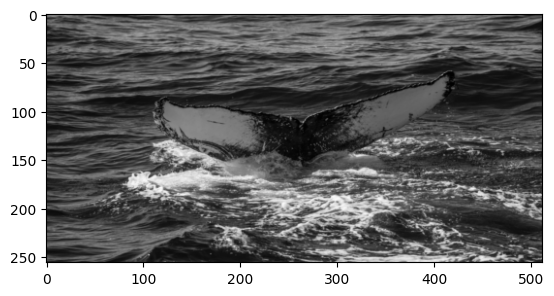

In [ ]:
plt.imshow(next(iter(train_set))[0].permute(1, 2, 0).numpy())

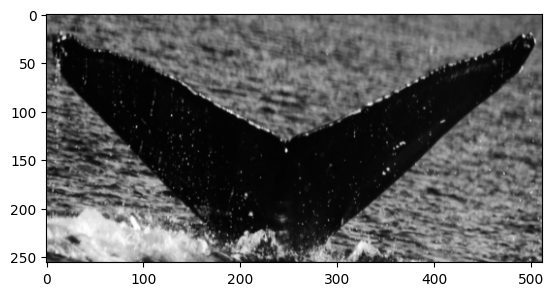

In [ ]:
plt.imshow(next(iter(valid_set))[0].permute(1, 2, 0).numpy())


In [ ]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_tasks = 20

n_way   = 5
n_shot  = 5
n_query = 5

In [ ]:
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_task_per_epoch
)

valid_sampler = TaskSampler(
    valid_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn
)

valid_loader = DataLoader(
    valid_set,
    batch_sampler=valid_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=valid_sampler.episodic_collate_fn
)

In [ ]:
n_epochs = 50
learning_rate = 1e-2

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)


In [ ]:
# optimizer = Adam(few_shot_classifier.parameters(), lr=learning_rate)
optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

### Training functions

In [7]:
def training_epoch(
    model: FewShotClassifier,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn: Callable
):
    all_loss = []
    model.train()
    # with tqdm(
    #     enumerate(data_loader), total=len(data_loader), desc="Training"
    # ) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in enumerate(data_loader):
        optimizer.zero_grad()
        model.process_support_set(
            support_images.to(device), support_labels.to(device)
        )
        classification_scores = model(query_images.to(device))

        loss = loss_fn(classification_scores, query_labels.to(device))
        loss.backward()
        optimizer.step()

        all_loss += [loss.item()]

        # tqdm_train.set_postfix(loss=np.mean(all_loss))

    return np.mean(all_loss)

### Train network

In [ ]:

best_state = few_shot_classifier.state_dict()
best_valid_acc = 0.0

early_stopping = 10

train_losses = []
valid_accs = []
for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}")
    epoch_loss = training_epoch(few_shot_classifier, train_loader, optimizer, loss_fn)
    train_losses += [epoch_loss]

    valid_acc = evaluate(
        few_shot_classifier, valid_loader, device=device, tqdm_prefix="Validation"
    )


    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_state = few_shot_classifier.state_dict()
        print("Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152")
        torch.save(few_shot_classifier.state_dict, '/content/drive/MyDrive/prototypical_network_resnet152')

    valid_accs += [valid_acc]

    optimizer.step()


Epoch 1


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s, accuracy=0.434]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 2


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s, accuracy=0.426]


Epoch 3



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.54]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 4


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, accuracy=0.538]


Epoch 5



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s, accuracy=0.58]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 6


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, accuracy=0.59]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 7


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s, accuracy=0.638]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 8


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.644]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 9


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.682]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 10


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.672]


Epoch 11



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s, accuracy=0.736]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 12


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s, accuracy=0.732]


Epoch 13



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s, accuracy=0.742]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 14


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s, accuracy=0.766]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 15


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.776]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 16


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.72it/s, accuracy=0.752]


Epoch 17



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s, accuracy=0.788]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 18


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.816]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 19


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s, accuracy=0.758]


Epoch 20



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s, accuracy=0.798]


Epoch 21



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s, accuracy=0.786]


Epoch 22



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s, accuracy=0.792]


Epoch 23



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.86]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 24


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.86]


Epoch 25



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s, accuracy=0.846]


Epoch 26



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, accuracy=0.858]


Epoch 27



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.73it/s, accuracy=0.842]


Epoch 28



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, accuracy=0.846]


Epoch 29



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s, accuracy=0.824]


Epoch 30



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.856]


Epoch 31



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.832]


Epoch 32



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.862]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 33


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s, accuracy=0.874]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 34


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s, accuracy=0.792]


Epoch 35



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.858]


Epoch 36



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, accuracy=0.842]


Epoch 37



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, accuracy=0.87]


Epoch 38



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s, accuracy=0.868]


Epoch 39



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, accuracy=0.85]


Epoch 40



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.884]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 41


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.73it/s, accuracy=0.904]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 42


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s, accuracy=0.848]


Epoch 43



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.78it/s, accuracy=0.866]


Epoch 44



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s, accuracy=0.848]


Epoch 45



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s, accuracy=0.904]


Epoch 46



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s, accuracy=0.886]


Epoch 47



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s, accuracy=0.924]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 48


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s, accuracy=0.87]


Epoch 49



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.876]


Epoch 50



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s, accuracy=0.868]


Epoch 51



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s, accuracy=0.868]


Epoch 52



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, accuracy=0.9]


Epoch 53



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s, accuracy=0.884]


Epoch 54



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s, accuracy=0.852]


Epoch 55



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s, accuracy=0.892]


Epoch 56



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s, accuracy=0.874]


Epoch 57



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.87]


Epoch 58



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.898]


Epoch 59



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s, accuracy=0.878]


Epoch 60



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s, accuracy=0.872]


Epoch 61



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s, accuracy=0.898]


Epoch 62



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, accuracy=0.892]


Epoch 63



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s, accuracy=0.884]


Epoch 64



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s, accuracy=0.9]


Epoch 65



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s, accuracy=0.872]


Epoch 66



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.93]


Best performing model, saving state to /content/drive/MyDrive/prototypical_network_resnet152

Epoch 67


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s, accuracy=0.892]


Epoch 68



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s, accuracy=0.904]


Epoch 69



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s, accuracy=0.834]


Epoch 70



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s, accuracy=0.918]


Epoch 71



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s, accuracy=0.926]


Epoch 72



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s, accuracy=0.886]


Epoch 73



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s, accuracy=0.872]


Epoch 74



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s, accuracy=0.882]


Epoch 75



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.73it/s, accuracy=0.854]


Epoch 76



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.87]


Epoch 77



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s, accuracy=0.892]


Epoch 78



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s, accuracy=0.872]


Epoch 79



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, accuracy=0.896]


Epoch 80



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s, accuracy=0.89]


Epoch 81



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s, accuracy=0.882]


Epoch 82



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.866]


Epoch 83



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.72it/s, accuracy=0.906]


Epoch 84



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s, accuracy=0.892]


Epoch 85



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, accuracy=0.892]


Epoch 86



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s, accuracy=0.89]


Epoch 87



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s, accuracy=0.902]


Epoch 88



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.908]


Epoch 89



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s, accuracy=0.878]


Epoch 90



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s, accuracy=0.886]


Epoch 91



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, accuracy=0.908]


Epoch 92



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.75it/s, accuracy=0.904]


Epoch 93



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s, accuracy=0.884]


Epoch 94



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s, accuracy=0.86]


Epoch 95



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s, accuracy=0.894]


Epoch 96



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s, accuracy=0.888]


Epoch 97



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s, accuracy=0.896]


Epoch 98



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, accuracy=0.888]


Epoch 99



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s, accuracy=0.89]


Epoch 100



Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s, accuracy=0.91]


In [ ]:
torch.save(few_shot_classifier.state_dict, '/content/prototypical_network_v1')

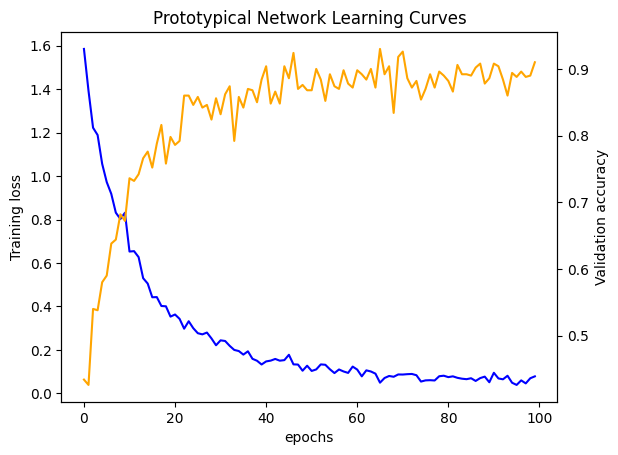

In [ ]:
fig,ax = plt.subplots()

plt.title('Prototypical Network Learning Curves')

ax.plot(train_losses, color='blue')
ax.set_xlabel("epochs")
ax.set_ylabel('Training loss')

ax2=ax.twinx()
ax2.plot(valid_accs, color='orange')
ax2.set_ylabel('Validation accuracy')

plt.show()
fig.savefig('/content/prototypical_network_resnet152_learning_curves_100epochs.png', format='png')

# 5-fold cross validation for the following shots

* 1-shot 10-way
* 5-shot 10-way
* 10-shot 10-way

In [17]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_tasks = 20

n_way   = 10
n_shot  = 1
n_query = 10

In [18]:
n_epochs = 50
learning_rate = 1e-2

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [19]:
# Load dataset
images_and_ids = pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
images_and_ids = images_and_ids[images_and_ids['class_count'] > 10]
images_and_ids

,Image,Id,class_count
0,0000e88ab.jpg,w_f48451c,14
3,000a6daec.jpg,w_dd88965,16
6,001cae55b.jpg,w_581ba42,14
11,004e8ad5b.jpg,w_3de579a,54
12,004f87702.jpg,w_1d0830e,11
...,...,...,...
15688,ffca5cb22.jpg,w_51e7506,15
15689,ffcd5efdc.jpg,w_f765256,34
15691,ffe52d320.jpg,w_bc285a6,21
15693,ffef89eed.jpg,w_9c506f6,62


In [20]:
whale_ids = np.unique(images_and_ids['Id'])
len(whale_ids)

227

In [21]:
# Create folds
num_folds = 5
folds = []
for i in range(num_folds):
  start_fold = (len(whale_ids)//num_folds)*i
  end_fold   = (len(whale_ids)//num_folds)*(i+1)
  if i == num_folds-1:
    end_fold = len(whale_ids)

  fold = whale_ids[start_fold:end_fold]
  folds += [fold]

In [22]:
transform = transforms.Compose(
        [
              transforms.Grayscale(num_output_channels=3),
              transforms.Resize((256, 512)),
              transforms.ToTensor(),
        ])

In [23]:
train_losses_mean, train_losses_std = [], []
valid_accs_mean, valid_accs_std     = [], []
for fold in range(num_folds):
  print(f'Fold {fold+1}')

  # Creating training/validation folds
  validation_fold = folds[i]
  training_folds = []
  for i in range(num_folds):
    if i != fold:
      training_folds.extend(folds[i])

  train_df = images_and_ids[images_and_ids['Id'].isin(training_folds)]
  valid_df = images_and_ids[images_and_ids['Id'].isin(validation_fold)]


  # Creating training/validation PyTorch datasets
  train_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=train_df,
      transform=transform

  )

  valid_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=valid_df,
      transform=transform
  )

  # Create TaskSamplers
  train_sampler = TaskSampler(
      train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_task_per_epoch
  )

  valid_sampler = TaskSampler(
      valid_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
  )

  # Create DataLoaders
  train_loader = DataLoader(
      train_set,
      batch_sampler=train_sampler,
      num_workers=12,
      pin_memory=True,
      collate_fn=train_sampler.episodic_collate_fn
  )

  valid_loader = DataLoader(
      valid_set,
      batch_sampler=valid_sampler,
      num_workers=12,
      pin_memory=True,
      collate_fn=valid_sampler.episodic_collate_fn
  )

  # Train and Validate
  cnn = resnet12().to(device)
  few_shot_classifier = PrototypicalNetworks(cnn).to(device)

  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

  train_losses = []
  valid_accs = []
  for epoch in tqdm(range(n_epochs)):
      epoch_loss = training_epoch(few_shot_classifier, train_loader, optimizer, loss_fn)
      train_losses += [epoch_loss]

      valid_acc = evaluate(
          few_shot_classifier, valid_loader, device=device, use_tqdm=False
      )

      valid_accs += [valid_acc]

      optimizer.step()


  train_losses_mean += [np.mean(train_losses)]
  train_losses_std  += [np.std(train_losses)]

  valid_accs_mean += [np.mean(valid_accs)]
  valid_accs_std  += [np.std(valid_accs)]

  print(f'Average fold validation accuracy = {np.mean(valid_accs)} {chr(177)}{np.std(valid_accs)}')

Fold 1


  0%|          | 0/50 [00:11<?, ?it/s]


OutOfMemoryError: ignored